# The preprocesing file of the assignment project

Since the main goal of this project isn't the final results, I will make toy dataset with small number of files. <br> 
For more convenience I'll take files with most common labels to avoid the situation, where there is only one example with certain label.. <br>
The problem with different durations I decided to solve like below:<br>
&#8226; First I'll calculate the durations of all audio files, and then pick some threshold(~mean value).<br>
&#8226; All the files that have durations less than the threshold I'll double until they reach the threshold.<br>
&#8226; Then I'll cut the whole audio file into equal segments and make mel-spectograms from them. <br> <br>
<b>P.S. Apparently by doing that I will miss some information from files with longer duration, but as I noticed most of the longer files just repetition of same particular sound so I assume that, that sound is occurred in the first seconds as well.<b>

## Notebook map

&#8226; Extract the most common labels and make toy dataset<br> 
&#8226; Label encoder <br>
&#8226; Find 'mean' threshold of dataset and adjust durations to that <br> 
&#8226; Make segments from waverows <br>
&#8226; Make spectograms from segments

In [1]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import pandas as pd
from tqdm import tqdm
import librosa.feature
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
def extract_waverow(filename, folder='train_curated'):
    """ Extract waverow from audio file """
    path = os.path.join(folder, filename)
    y, _  = librosa.load(path)
    return y


def calculate_duration(y, sr=22050):
    """ Calculate the duration of waverow in seconds """
    return len(y) / sr


def adjust_duration(y, threshold=10, sr=22050): 
    """
    If duration is less than threshold doubles
    until it reaches theshold
    """
    duration = len(y) / sr
    new_duration = 0.
    times = 0
    
    while new_duration<threshold:
        new_duration = new_duration + duration
        times+=1
    
    return np.resize(y, int(times)*y.shape[0])


def extract_segments(adjusted_y, num_segments=7, hop_length=1*22050, frame_length=3*22050):
    """
    Split waverow to 7 segments with hop lenght = 1 sec
    and duration of segment = 3 secs
    """
    segments = []
    
    for i in range(0, num_segments):
        start = int(i*hop_length)
        end = start + frame_length
        segment = adjusted_y[start:end]
        segments.append(segment)
    
    return np.array(segments)


def extract_spectogram(segments):
    """ Build mel-spectograms for given list of segmnets """
    spectograms = []
    
    for segment in segments:
        mel_spec = librosa.feature.melspectrogram(segment, n_fft=2048, hop_length=512, 
                                                n_mels=96, sr=22050)
        D =librosa.power_to_db(mel_spec, ref=np.max)
        spectograms.append(D)
        
    return np.array(spectograms)

## Toy dataset and encoder

In [3]:
frame = pd.read_csv('train_curated.csv') # Csv with file names and labels

# Extracting list of most common labesl
common_labels = frame['labels'].value_counts()[:10].index.to_list()

condition = ((frame['labels']==common_labels[0]) |
             (frame['labels']==common_labels[1]) |
             (frame['labels']==common_labels[2]) |
             (frame['labels']==common_labels[3]) |
             (frame['labels']==common_labels[4]) |
             (frame['labels']==common_labels[5]) |
             (frame['labels']==common_labels[6]) |
             (frame['labels']==common_labels[7]) |
             (frame['labels']==common_labels[8]) |
             (frame['labels']==common_labels[9]))

frame = frame.loc[condition]

In [4]:
## Label encoder
encoder = LabelEncoder()
encoded = encoder.fit_transform(frame['labels'])
frame['labels'] = encoded

# For the sake of convenience
frame = frame.reset_index(drop=True)

frame['labels'].value_counts().to_frame()

,labels
9,75
8,75
7,75
6,75
5,75
4,75
3,75
2,75
1,75
0,74


## Adjust durations

In [5]:
# View
frame.head()

,fname,labels
0,001ec0ad.wav,2
1,0026f116.wav,2
2,009ca29f.wav,0
3,00c91dfc.wav,0
4,0217540b.wav,9


In [6]:
frame['y'] = frame['fname'].apply(extract_waverow)

frame['duration'] = frame['y'].apply(calculate_duration)

frame['duration'].describe().to_frame()

,duration
count,749.000000
mean,7.241677
std,7.848933
min,0.300000
25%,1.207438
50%,3.703583
75%,10.871202
max,29.895147


#### From there I have decided the threshold(10) and the number of segments(7)

In [7]:
frame['adjusted_y'] = frame['y'].apply(adjust_duration)

In [8]:
frame.head()

,fname,labels,y,duration,adjusted_y
0,001ec0ad.wav,2,"[-0.0001602216, -0.0006380982, -0.0003406805, ...",1.518730,"[-0.0001602216, -0.0006380982, -0.0003406805, ..."
1,0026f116.wav,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.375011,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,009ca29f.wav,0,"[-9.4822633e-07, 1.3251653e-06, -1.945937e-06,...",7.411973,"[-9.4822633e-07, 1.3251653e-06, -1.945937e-06,..."
3,00c91dfc.wav,0,"[-0.0006966979, -0.00063006696, -0.0014202215,...",17.600726,"[-0.0006966979, -0.00063006696, -0.0014202215,..."
4,0217540b.wav,9,"[-0.00032528912, -0.00048533728, -0.0003301644...",11.000000,"[-0.00032528912, -0.00048533728, -0.0003301644..."


## Make segments and spectograms

In [9]:
# Extracting segments from adjusted waverow
frame['segments'] = frame['adjusted_y'].apply(extract_segments)

# Making spectograms from segments
frame['spectograms'] = frame['segments'].apply(extract_spectogram)

## Final view

In [10]:
final = frame[['spectograms', 'labels']]

# splites list into rows in dataframe
final = final.explode('spectograms')

final = final.reset_index()
final = final[['spectograms', 'labels']]

In [11]:
# Final view
final.sample(5)

,spectograms,labels
1672,"[[-14.897877, -7.6572475, -8.362596, -15.10186...",4
1168,"[[-24.485703, -24.746014, -29.43417, -28.21462...",3
1533,"[[-11.7403965, -14.532724, -17.366661, -17.555...",9
147,"[[-20.860886, -25.091, -26.894033, -25.69669, ...",0
4768,"[[-15.835694, -16.360899, -12.992587, -9.14860...",1


In [12]:
print(f'Final shape: {final.shape}')

Final shape: (5243, 2)


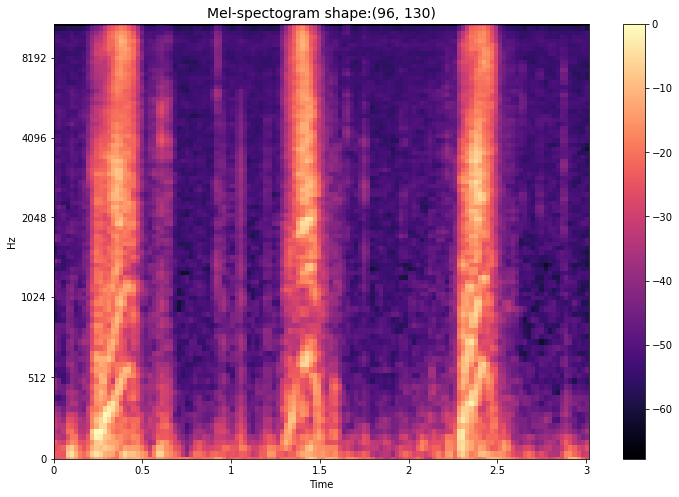

In [13]:
# Cheking if everything is ok
q = final.loc[999, 'spectograms']

plt.figure(figsize=(12,8))

spec = librosa.display.specshow(q, y_axis='mel', sr=22050, x_axis='time')
title = 'Mel-spectogram shape:' + str(final.loc[0, 'spectograms'].shape)
plt.title(title, fontsize=14)

plt.colorbar()
plt.show()

#### Pandas
If you wonder about why I used pandas frames, the answer is because I am not so experienced in signal processing, so I need more visual information to understand the whole process of preprocessing the data.

In [14]:
# Saving numpy array
training_data = final.values
#np.save('training_data.npy', training_data)